NOTE: In this notebook we do not run the tree creation code and the matrix creations, since it is a very heavy operation.
We download a pre-made matrices for ease of usage.
Run this only in the first time to download the data

In [1]:
!pip install pytorch-tabnet
!pip install xgboost
#!gdown --id 1FCaUqClUl6zKb9fszETEIJsLXscTsz12
#!gdown --id "1BtJR_oIb1RHCS5rcLYrf--gZZXC2YuG8&confirm=t"
#!unzip results_mushroom.zip

DEPRECATION: pytorch-lightning 1.5.9 has a non-standard dependency specifier torch>=1.7.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: pytorch-lightning 1.5.9 has a non-standard dependency specifier torch>=1.7.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
import pickle
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score


class MushroomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.data[idx]), torch.LongTensor([self.labels[idx]])


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


HERMANN

In [3]:
class ModifiedResNet(nn.Module):
    def __init__(self):
        super(ModifiedResNet, self).__init__()
        # Load a pre-trained ResNet model
        resnet = models.resnet18(pretrained=True)
        # Remove the last layer (fully connected layer)
        self.resnet_features = nn.Sequential(*list(resnet.children())[:-1])
        # Modify the first layer to accept grayscale images
        self.resnet_features[0] = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Add Batch Normalization
        self.batch_norm = nn.BatchNorm1d(512)
        # Add dropout to reduce overfitting
        self.dropout = nn.Dropout(p=0.2)
        # Define additional layers for classification
        self.fc1 = nn.Linear(512, 64)
        self.fc2 = nn.Linear(64, 2)  # Output has 2 classes

    def forward(self, x):
        x = self.resnet_features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.batch_norm(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [4]:
def run_HERMANN(train_data, train_labels, val_data, val_labels,test_data, test_labels):
    # Create datasets and dataloaders
    train_dataset = MushroomDataset(train_data, train_labels)
    val_dataset = MushroomDataset(val_data, val_labels)
    test_dataset = MushroomDataset(test_data, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Initialize model, loss function, and optimizer
    model = ModifiedResNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Early stopping parameters
    patience = 5
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_weights = None

    # Training loop
    num_epochs = 1000
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm.tqdm(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, labels.to(device).squeeze())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in tqdm.tqdm(val_loader):
                outputs = model(inputs.to(device))
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels.to(device).squeeze()).sum().item()
                val_loss += criterion(outputs, labels.to(device).squeeze()).item()
        val_loss /= len(val_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss}, Accuracy on validation set: {100 * correct / total:.2f}%, Validation Loss: {val_loss:.4f}")

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            # Save the best model weights
            best_model_weights = model.state_dict()
            if best_val_loss == 0.:
              print(f'Early stopping after {epoch + 1} epochs.')
              break
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f'Early stopping after {epoch + 1} epochs.')
                break

    # Load the best model weights for testing
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)

    # Test loop
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm.tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels.squeeze()).sum().item()

            # Collect all labels and predictions for metrics calculation
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy())

    # Calculate accuracy
    accuracy = correct / total
    print(f"Accuracy on test set: {100 * accuracy:.2f}%")

    # Calculate AUC
    auc = roc_auc_score(all_labels, [prob[1] for prob in all_probs])
    print(f"AUC on test set: {auc:.2f}")

    # Calculate F1 score
    f1 = f1_score(all_labels, all_preds, average='binary')
    print(f"F1 score on test set: {f1:.2f}")
    return accuracy, auc, f1

TABNET

In [5]:
from pytorch_tabnet.tab_model import TabNetClassifier

def run_TabNet(train_data, train_labels,val_data, val_labels,test_data, test_labels):
    # Define the TabNetClassifier model
    model = TabNetClassifier()

    # Fit the model
    model.fit(
        X_train=train_data.values.astype(float),
        y_train=train_labels,
        eval_set=[(val_data.values, val_labels)],
        patience=5,  # Early stopping rounds
        max_epochs=1000,  # Maximum number of epochs
        eval_metric=['accuracy'],  # Evaluation metric
        loss_fn=torch.nn.CrossEntropyLoss(),  # Loss function
    )

    # Evaluate the best model on the test set
    test_predictions = model.predict(test_data.values.astype(float))
    test_probs = model.predict_proba(test_data.values.astype(float))

    # Calculate accuracy
    accuracy = accuracy_score(test_labels, test_predictions)
    print(f"Accuracy on test set: {100 * accuracy:.2f}%")

    # Calculate AUC
    auc = roc_auc_score(test_labels, test_probs[:, 1])
    print(f"AUC on test set: {auc:.2f}")

    # Calculate F1 score
    f1 = f1_score(test_labels, test_predictions, average='binary')
    print(f"F1 score on test set: {f1:.2f}")
    return accuracy, auc, f1

XGBOOST

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb

# # Load data and labels
# raw = pd.read_csv('mushroom.csv')
# tags = raw["class"]
# data = raw.drop(columns=["class"])
# tags = np.array([i == "p" for i in tags]).astype(np.int64)  # binary
# data_encoded = pd.get_dummies(data)

# # Split data into training, validation, and test sets randomly
# #data_to_use, loset_data, labels_to_use, losed_labels = train_test_split(data_encoded, tags, test_size=0.99, random_state=42)
# data_to_use, _,labels_to_use, _ = data_encoded, None, tags, None

# train_data, test_val_data, train_labels, test_val_labels = train_test_split(data_to_use, labels_to_use, test_size=0.3,
#                                                                           random_state=42)
# val_data, test_data, val_labels, test_labels = train_test_split(test_val_data, test_val_labels, test_size=0.5,
#                                                               random_state=42)

def run_Xgboost(train_data, train_labels,val_data, val_labels,test_data, test_labels):
    # Define XGBoost model
    model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

    # Fit the model
    model.fit(
        train_data.values.astype(float),
        train_labels,
        eval_set=[(val_data.values, val_labels)],
        eval_metric='error',  # Evaluation metric
        early_stopping_rounds=5,  # Early stopping rounds
        verbose=True
    )

    # Evaluate the best model on the test set
    test_predictions = model.predict(test_data.values.astype(float))
    test_probs = model.predict_proba(test_data.values.astype(float))

    # Calculate accuracy
    accuracy = accuracy_score(test_labels, test_predictions)
    print(f"Accuracy on test set: {100 * accuracy:.2f}%")

    # Calculate AUC
    auc = roc_auc_score(test_labels, test_probs[:, 1])
    print(f"AUC on test set: {auc:.2f}")

    # Calculate F1 score
    f1 = f1_score(test_labels, test_predictions, average='binary')
    print(f"F1 score on test set: {f1:.2f}")
    return accuracy, auc, f1

In [7]:
def run_all(size):
    # Load data and labels
    tags = pd.read_csv('mushroom.csv')["class"]
    tags = np.array([i == "p" for i in tags]).astype(np.int64)  # binary

    with open("results.pkl", "rb") as f:
        matrices_result, new_order_names = pickle.load(f)

    matrices_result = matrices_result[:, np.newaxis, :, :]  # 61069, 1, 39, 119

    # Split data into training, validation, and test sets randomly
    if size == 0:
        data_to_use, _,labels_to_use, _ = matrices_result, None, tags, None
    else:
        data_to_use, loset_data, labels_to_use, losed_labels = train_test_split(matrices_result, tags, test_size=size, random_state=42)

    del matrices_result

    train_data, test_val_data, train_labels, test_val_labels = train_test_split(data_to_use, labels_to_use, test_size=0.3, random_state=42)
    val_data, test_data, val_labels, test_labels = train_test_split(test_val_data, test_val_labels, test_size=0.5, random_state=42)
    h_acc, h_auc, h_f1 = run_HERMANN(train_data, train_labels,val_data, val_labels,test_data, test_labels)

    #########################
    # Load data and labels
    raw = pd.read_csv('mushroom.csv')
    tags = raw["class"]
    data = raw.drop(columns=["class"])
    tags = np.array([i == "p" for i in tags]).astype(np.int64)  # binary
    data_encoded = pd.get_dummies(data)

    # Split data into training, validation, and test sets randomly
    if size == 0:
        data_to_use, _,labels_to_use, _ = data_encoded, None, tags, None
    else:
        data_to_use, loset_data, labels_to_use, losed_labels = train_test_split(data_encoded, tags, test_size=size, random_state=42)

    train_data, test_val_data, train_labels, test_val_labels = train_test_split(data_to_use, labels_to_use, test_size=0.3,
                                                                              random_state=42)
    val_data, test_data, val_labels, test_labels = train_test_split(test_val_data, test_val_labels, test_size=0.5,
                                                                  random_state=42)
    t_acc, t_auc, t_f1 = run_TabNet(train_data, train_labels,val_data, val_labels,test_data, test_labels)
    x_acc, x_auc, x_f1 = run_Xgboost(train_data, train_labels,val_data, val_labels,test_data, test_labels)

    return {"hermann":[h_acc, h_auc, h_f1],
            "tabnet":[t_acc, t_auc, t_f1],
            "xgboost":[x_acc, x_auc, x_f1]}

  0%|                                                                                                                                                                           | 0/668 [00:00<?, ?it/s]/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:01<00:00, 112.32it/s]


Epoch 1/1000, Loss: 135.89531973283738, Accuracy on validation set: 77.97%, Validation Loss: 0.5691


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:01<00:00, 116.40it/s]


Epoch 2/1000, Loss: 33.52680317591876, Accuracy on validation set: 98.42%, Validation Loss: 0.0425


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:01<00:00, 114.50it/s]


Epoch 3/1000, Loss: 22.492869800014887, Accuracy on validation set: 99.67%, Validation Loss: 0.0126


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:01<00:00, 112.84it/s]


Epoch 4/1000, Loss: 15.043849868321558, Accuracy on validation set: 96.89%, Validation Loss: 0.0786


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:01<00:00, 111.02it/s]


Epoch 5/1000, Loss: 16.671196692434023, Accuracy on validation set: 99.18%, Validation Loss: 0.0290


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:01<00:00, 113.28it/s]


Epoch 6/1000, Loss: 13.212344919869793, Accuracy on validation set: 98.98%, Validation Loss: 0.0319


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:01<00:00, 113.93it/s]


Epoch 7/1000, Loss: 7.991213834335213, Accuracy on validation set: 99.99%, Validation Loss: 0.0026


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:01<00:00, 112.95it/s]


Epoch 8/1000, Loss: 10.957026649673935, Accuracy on validation set: 99.90%, Validation Loss: 0.0026


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:01<00:00, 113.42it/s]


Epoch 9/1000, Loss: 9.576417939111707, Accuracy on validation set: 99.74%, Validation Loss: 0.0079


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:01<00:00, 112.78it/s]


Epoch 10/1000, Loss: 5.974850153139414, Accuracy on validation set: 100.00%, Validation Loss: 0.0002


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:01<00:00, 114.04it/s]


Epoch 11/1000, Loss: 6.550868204009021, Accuracy on validation set: 98.76%, Validation Loss: 0.0402


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:01<00:00, 113.30it/s]


Epoch 12/1000, Loss: 6.531420928826265, Accuracy on validation set: 99.99%, Validation Loss: 0.0005


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:01<00:00, 111.80it/s]


Epoch 13/1000, Loss: 7.926611395923828, Accuracy on validation set: 97.49%, Validation Loss: 0.0953


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:01<00:00, 113.56it/s]


Epoch 14/1000, Loss: 5.128764669492739, Accuracy on validation set: 98.90%, Validation Loss: 0.0583


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:01<00:00, 114.91it/s]


Epoch 15/1000, Loss: 6.967936793516856, Accuracy on validation set: 99.97%, Validation Loss: 0.0019
Early stopping after 15 epochs.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:01<00:00, 114.49it/s]


Accuracy on test set: 99.99%
AUC on test set: 1.00
F1 score on test set: 1.00


/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.67513 | val_0_accuracy: 0.49443 |  0:00:02s
epoch 1  | loss: 0.45414 | val_0_accuracy: 0.63472 |  0:00:04s
epoch 2  | loss: 0.21551 | val_0_accuracy: 0.7631  |  0:00:06s
epoch 3  | loss: 0.06913 | val_0_accuracy: 0.86288 |  0:00:08s
epoch 4  | loss: 0.04495 | val_0_accuracy: 0.92849 |  0:00:11s
epoch 5  | loss: 0.03058 | val_0_accuracy: 0.94945 |  0:00:13s
epoch 6  | loss: 0.0159  | val_0_accuracy: 0.96943 |  0:00:15s
epoch 7  | loss: 0.01169 | val_0_accuracy: 0.9917  |  0:00:17s
epoch 8  | loss: 0.01023 | val_0_accuracy: 0.99203 |  0:00:19s
epoch 9  | loss: 0.01113 | val_0_accuracy: 0.99891 |  0:00:21s
epoch 10 | loss: 0.00677 | val_0_accuracy: 0.99891 |  0:00:23s
epoch 11 | loss: 0.00984 | val_0_accuracy: 0.99913 |  0:00:26s
epoch 12 | loss: 0.01259 | val_0_accuracy: 0.99945 |  0:00:28s
epoch 13 | loss: 0.00853 | val_0_accuracy: 0.99956 |  0:00:30s
epoch 14 | loss: 0.00561 | val_0_accuracy: 1.0     |  0:00:32s
epoch 15 | loss: 0.00646 | val_0_accuracy: 0.99945 |  0

/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Accuracy on test set: 100.00%
AUC on test set: 1.00
F1 score on test set: 1.00
[0]	validation_0-error:0.29629
[1]	validation_0-error:0.15087
[2]	validation_0-error:0.07969
[3]	validation_0-error:0.07391
[4]	validation_0-error:0.06299
[5]	validation_0-error:0.06212
[6]	validation_0-error:0.04858
[7]	validation_0-error:0.04978
[8]	validation_0-error:0.04672
[9]	validation_0-error:0.05098
[10]	validation_0-error:0.03886
[11]	validation_0-error:0.03581
[12]	validation_0-error:0.03264


/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-error:0.02915
[14]	validation_0-error:0.02675
[15]	validation_0-error:0.02642
[16]	validation_0-error:0.02642
[17]	validation_0-error:0.02609
[18]	validation_0-error:0.02391
[19]	validation_0-error:0.02434
[20]	validation_0-error:0.01681
[21]	validation_0-error:0.01856
[22]	validation_0-error:0.01452
[23]	validation_0-error:0.01277
[24]	validation_0-error:0.01081
[25]	validation_0-error:0.00753
[26]	validation_0-error:0.00644
[27]	validation_0-error:0.00775
[28]	validation_0-error:0.00710
[29]	validation_0-error:0.00633
[30]	validation_0-error:0.00633
[31]	validation_0-error:0.00644
[32]	validation_0-error:0.00557
[33]	validation_0-error:0.00600
[34]	validation_0-error:0.00579
[35]	validation_0-error:0.00579
[36]	validation_0-error:0.00426
[37]	validation_0-error:0.00437
[38]	validation_0-error:0.00415
[39]	validation_0-error:0.00404
[40]	validation_0-error:0.00295
[41]	validation_0-error:0.00240
[42]	validation_0-error:0.00240
[43]	validation_0-error:0.00240
[44]	val

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 117.49it/s]


Epoch 1/1000, Loss: 111.95708594657481, Accuracy on validation set: 91.40%, Validation Loss: 0.2425


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 115.85it/s]


Epoch 2/1000, Loss: 35.684754241257906, Accuracy on validation set: 94.39%, Validation Loss: 0.1304


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 116.20it/s]


Epoch 3/1000, Loss: 15.585204952862114, Accuracy on validation set: 98.78%, Validation Loss: 0.0326


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 111.50it/s]


Epoch 4/1000, Loss: 15.722596903389785, Accuracy on validation set: 98.47%, Validation Loss: 0.0399


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 111.46it/s]


Epoch 5/1000, Loss: 14.565589830395766, Accuracy on validation set: 99.50%, Validation Loss: 0.0117


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 112.17it/s]


Epoch 6/1000, Loss: 8.734135354447062, Accuracy on validation set: 98.73%, Validation Loss: 0.0360


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 112.37it/s]


Epoch 7/1000, Loss: 6.950497434096178, Accuracy on validation set: 99.83%, Validation Loss: 0.0067


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 127.95it/s]


Epoch 8/1000, Loss: 7.233476284716744, Accuracy on validation set: 96.07%, Validation Loss: 0.1067


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 109.59it/s]


Epoch 9/1000, Loss: 3.886148570665682, Accuracy on validation set: 99.43%, Validation Loss: 0.0242


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 112.63it/s]


Epoch 10/1000, Loss: 8.976507473678794, Accuracy on validation set: 99.96%, Validation Loss: 0.0028


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 112.87it/s]


Epoch 11/1000, Loss: 6.69639850067324, Accuracy on validation set: 99.63%, Validation Loss: 0.0154


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 113.45it/s]


Epoch 12/1000, Loss: 4.196505190804601, Accuracy on validation set: 100.00%, Validation Loss: 0.0006


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 112.82it/s]


Epoch 13/1000, Loss: 4.019260116678197, Accuracy on validation set: 98.03%, Validation Loss: 0.0736


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 112.74it/s]


Epoch 14/1000, Loss: 4.682829593533825, Accuracy on validation set: 99.93%, Validation Loss: 0.0025


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 114.93it/s]


Epoch 15/1000, Loss: 4.269881375876139, Accuracy on validation set: 99.87%, Validation Loss: 0.0028


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 115.59it/s]


Epoch 16/1000, Loss: 3.7940167332308192, Accuracy on validation set: 99.67%, Validation Loss: 0.0103


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 113.25it/s]


Epoch 17/1000, Loss: 4.631909464173077, Accuracy on validation set: 99.93%, Validation Loss: 0.0041
Early stopping after 17 epochs.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 114.76it/s]


Accuracy on test set: 99.85%
AUC on test set: 1.00
F1 score on test set: 1.00


/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.7347  | val_0_accuracy: 0.60044 |  0:00:01s
epoch 1  | loss: 0.63474 | val_0_accuracy: 0.61354 |  0:00:02s
epoch 2  | loss: 0.55575 | val_0_accuracy: 0.60524 |  0:00:03s
epoch 3  | loss: 0.42953 | val_0_accuracy: 0.63537 |  0:00:04s
epoch 4  | loss: 0.28519 | val_0_accuracy: 0.70131 |  0:00:05s
epoch 5  | loss: 0.18226 | val_0_accuracy: 0.78559 |  0:00:06s
epoch 6  | loss: 0.11344 | val_0_accuracy: 0.82838 |  0:00:07s
epoch 7  | loss: 0.08874 | val_0_accuracy: 0.80677 |  0:00:08s
epoch 8  | loss: 0.06905 | val_0_accuracy: 0.84738 |  0:00:09s
epoch 9  | loss: 0.04461 | val_0_accuracy: 0.92271 |  0:00:10s
epoch 10 | loss: 0.05492 | val_0_accuracy: 0.93799 |  0:00:11s
epoch 11 | loss: 0.03675 | val_0_accuracy: 0.96616 |  0:00:12s
epoch 12 | loss: 0.02331 | val_0_accuracy: 0.96092 |  0:00:13s
epoch 13 | loss: 0.01896 | val_0_accuracy: 0.97424 |  0:00:14s
epoch 14 | loss: 0.01873 | val_0_accuracy: 0.97795 |  0:00:15s
epoch 15 | loss: 0.01367 | val_0_accuracy: 0.98537 |  0

/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Accuracy on test set: 100.00%
AUC on test set: 1.00
F1 score on test set: 1.00
[0]	validation_0-error:0.32511
[1]	validation_0-error:0.16790
[2]	validation_0-error:0.13690
[3]	validation_0-error:0.06921
[4]	validation_0-error:0.05459
[5]	validation_0-error:0.04934
[6]	validation_0-error:0.04869
[7]	validation_0-error:0.04454
[8]	validation_0-error:0.04323
[9]	validation_0-error:0.04148
[10]	validation_0-error:0.03537
[11]	validation_0-error:0.03144
[12]	validation_0-error:0.02795
[13]	validation_0-error:0.02598
[14]	validation_0-error:0.02358
[15]	validation_0-error:0.02074
[16]	validation_0-error:0.02096
[17]	validation_0-error:0.02096
[18]	validation_0-error:0.01834
[19]	validation_0-error:0.01900
[20]	validation_0-error:0.01572
[21]	validation_0-error:0.01572
[22]	validation_0-error:0.01376
[23]	validation_0-error:0.01026
[24]	validation_0-error:0.01114
[25]	validation_0-error:0.00983
[26]	validation_0-error:0.00939
[27]	validation_0-error:0.00852
[28]	validation_0-error:0.00677
[29

/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Accuracy on test set: 99.85%
AUC on test set: 1.00
F1 score on test set: 1.00


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 116.64it/s]


Epoch 1/1000, Loss: 64.83318999409676, Accuracy on validation set: 67.96%, Validation Loss: 0.6755


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 114.28it/s]


Epoch 2/1000, Loss: 34.34870698302984, Accuracy on validation set: 80.84%, Validation Loss: 0.4617


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 116.67it/s]


Epoch 3/1000, Loss: 20.204005698673427, Accuracy on validation set: 98.14%, Validation Loss: 0.0574


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 112.59it/s]


Epoch 4/1000, Loss: 11.528944463469088, Accuracy on validation set: 93.72%, Validation Loss: 0.1712


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 112.91it/s]


Epoch 5/1000, Loss: 10.3556238245219, Accuracy on validation set: 97.71%, Validation Loss: 0.0633


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 115.72it/s]


Epoch 6/1000, Loss: 9.5644169987645, Accuracy on validation set: 98.42%, Validation Loss: 0.0422


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 115.80it/s]


Epoch 7/1000, Loss: 4.845185651967768, Accuracy on validation set: 97.05%, Validation Loss: 0.0777


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 113.09it/s]


Epoch 8/1000, Loss: 8.398399712750688, Accuracy on validation set: 97.76%, Validation Loss: 0.0637


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 111.76it/s]


Epoch 9/1000, Loss: 5.031191427959129, Accuracy on validation set: 91.10%, Validation Loss: 0.2955


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 113.58it/s]


Epoch 10/1000, Loss: 6.159081991238054, Accuracy on validation set: 97.54%, Validation Loss: 0.0700


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 109.41it/s]


Epoch 11/1000, Loss: 4.3378124294104055, Accuracy on validation set: 99.18%, Validation Loss: 0.0221


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 112.68it/s]


Epoch 12/1000, Loss: 2.900578149361536, Accuracy on validation set: 99.78%, Validation Loss: 0.0063


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 112.22it/s]


Epoch 13/1000, Loss: 3.6677433010190725, Accuracy on validation set: 99.34%, Validation Loss: 0.0240


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 115.34it/s]


Epoch 14/1000, Loss: 5.136966049554758, Accuracy on validation set: 99.02%, Validation Loss: 0.0381


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 110.20it/s]


Epoch 15/1000, Loss: 2.3324708183063194, Accuracy on validation set: 99.95%, Validation Loss: 0.0030


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 128.59it/s]


Epoch 16/1000, Loss: 1.910921439935919, Accuracy on validation set: 98.64%, Validation Loss: 0.0443


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 116.75it/s]


Epoch 17/1000, Loss: 4.705696010321844, Accuracy on validation set: 98.91%, Validation Loss: 0.0360


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 115.82it/s]


Epoch 18/1000, Loss: 3.8627744544064626, Accuracy on validation set: 99.13%, Validation Loss: 0.0310


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 115.96it/s]


Epoch 19/1000, Loss: 3.1146162693185033, Accuracy on validation set: 97.38%, Validation Loss: 0.0758


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 112.81it/s]


Epoch 20/1000, Loss: 3.3433671362581663, Accuracy on validation set: 98.25%, Validation Loss: 0.0576
Early stopping after 20 epochs.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 113.52it/s]


Accuracy on test set: 98.74%
AUC on test set: 1.00
F1 score on test set: 0.99


/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.8425  | val_0_accuracy: 0.56332 |  0:00:00s
epoch 1  | loss: 0.67617 | val_0_accuracy: 0.58352 |  0:00:00s
epoch 2  | loss: 0.64371 | val_0_accuracy: 0.55022 |  0:00:01s
epoch 3  | loss: 0.61214 | val_0_accuracy: 0.59116 |  0:00:01s
epoch 4  | loss: 0.58589 | val_0_accuracy: 0.59007 |  0:00:02s
epoch 5  | loss: 0.56193 | val_0_accuracy: 0.6179  |  0:00:02s
epoch 6  | loss: 0.5367  | val_0_accuracy: 0.62063 |  0:00:03s
epoch 7  | loss: 0.50105 | val_0_accuracy: 0.66485 |  0:00:03s
epoch 8  | loss: 0.45846 | val_0_accuracy: 0.65884 |  0:00:03s
epoch 9  | loss: 0.40144 | val_0_accuracy: 0.64138 |  0:00:04s
epoch 10 | loss: 0.34521 | val_0_accuracy: 0.68504 |  0:00:04s
epoch 11 | loss: 0.27015 | val_0_accuracy: 0.7107  |  0:00:05s
epoch 12 | loss: 0.22235 | val_0_accuracy: 0.73199 |  0:00:05s
epoch 13 | loss: 0.18062 | val_0_accuracy: 0.76638 |  0:00:05s
epoch 14 | loss: 0.13793 | val_0_accuracy: 0.77074 |  0:00:06s
epoch 15 | loss: 0.1261  | val_0_accuracy: 0.76801 |  0

/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Accuracy on test set: 98.09%
AUC on test set: 1.00
F1 score on test set: 0.98
[0]	validation_0-error:0.33242
[1]	validation_0-error:0.15611
[2]	validation_0-error:0.09771
[3]	validation_0-error:0.09007
[4]	validation_0-error:0.07096
[5]	validation_0-error:0.07424
[6]	validation_0-error:0.07424
[7]	validation_0-error:0.06987
[8]	validation_0-error:0.06277
[9]	validation_0-error:0.05677
[10]	validation_0-error:0.05786
[11]	validation_0-error:0.05568
[12]	validation_0-error:0.05349
[13]	validation_0-error:0.04585
[14]	validation_0-error:0.04640
[15]	validation_0-error:0.03493
[16]	validation_0-error:0.03821
[17]	validation_0-error:0.03330
[18]	validation_0-error:0.02511
[19]	validation_0-error:0.02183
[20]	validation_0-error:0.02020
[21]	validation_0-error:0.01747
[22]	validation_0-error:0.01419
[23]	validation_0-error:0.01201
[24]	validation_0-error:0.01146
[25]	validation_0-error:0.00764
[26]	validation_0-error:0.00819
[27]	validation_0-error:0.00819
[28]	validation_0-error:0.00710
[29]

/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Accuracy on test set: 99.95%
AUC on test set: 1.00
F1 score on test set: 1.00


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 97.62it/s]


Epoch 1/1000, Loss: 40.74976125359535, Accuracy on validation set: 74.02%, Validation Loss: 0.5141


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 97.98it/s]


Epoch 2/1000, Loss: 31.879718124866486, Accuracy on validation set: 63.21%, Validation Loss: 0.9918


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 97.84it/s]


Epoch 3/1000, Loss: 21.994211733341217, Accuracy on validation set: 81.77%, Validation Loss: 0.4377


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 98.48it/s]


Epoch 4/1000, Loss: 17.24571980535984, Accuracy on validation set: 84.28%, Validation Loss: 0.4922


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 98.61it/s]


Epoch 5/1000, Loss: 13.36093844473362, Accuracy on validation set: 93.67%, Validation Loss: 0.1759


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 96.17it/s]


Epoch 6/1000, Loss: 9.660544775426388, Accuracy on validation set: 87.34%, Validation Loss: 0.3486


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 98.94it/s]


Epoch 7/1000, Loss: 9.337877251207829, Accuracy on validation set: 95.31%, Validation Loss: 0.1361


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 98.42it/s]


Epoch 8/1000, Loss: 7.639347469434142, Accuracy on validation set: 95.20%, Validation Loss: 0.1305


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 99.07it/s]


Epoch 9/1000, Loss: 5.766868676058948, Accuracy on validation set: 95.41%, Validation Loss: 0.1556


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 108.96it/s]


Epoch 10/1000, Loss: 6.324844079092145, Accuracy on validation set: 96.40%, Validation Loss: 0.0876


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 108.59it/s]


Epoch 11/1000, Loss: 4.678923599887639, Accuracy on validation set: 97.27%, Validation Loss: 0.0844


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 109.62it/s]


Epoch 12/1000, Loss: 5.214516407810152, Accuracy on validation set: 93.67%, Validation Loss: 0.1602


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 97.84it/s]


Epoch 13/1000, Loss: 4.125836833147332, Accuracy on validation set: 97.71%, Validation Loss: 0.0610


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 98.17it/s]


Epoch 14/1000, Loss: 3.96271108626388, Accuracy on validation set: 95.52%, Validation Loss: 0.1150


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 96.81it/s]


Epoch 15/1000, Loss: 4.298168207984418, Accuracy on validation set: 97.27%, Validation Loss: 0.0874


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 97.35it/s]


Epoch 16/1000, Loss: 4.74957990180701, Accuracy on validation set: 97.82%, Validation Loss: 0.0762


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 96.46it/s]


Epoch 17/1000, Loss: 2.900560025125742, Accuracy on validation set: 98.03%, Validation Loss: 0.0403


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 94.36it/s]


Epoch 18/1000, Loss: 2.9037258948665112, Accuracy on validation set: 92.69%, Validation Loss: 0.2310


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 98.58it/s]


Epoch 19/1000, Loss: 2.8524169409647584, Accuracy on validation set: 98.47%, Validation Loss: 0.0488


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 95.71it/s]


Epoch 20/1000, Loss: 2.48651838186197, Accuracy on validation set: 98.36%, Validation Loss: 0.0627


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 93.65it/s]


Epoch 21/1000, Loss: 2.9257036781637, Accuracy on validation set: 99.24%, Validation Loss: 0.0302


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 98.63it/s]


Epoch 22/1000, Loss: 2.466721518430859, Accuracy on validation set: 98.14%, Validation Loss: 0.0402


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 95.87it/s]


Epoch 23/1000, Loss: 1.8187450455734506, Accuracy on validation set: 99.13%, Validation Loss: 0.0388


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 96.19it/s]


Epoch 24/1000, Loss: 3.564518379746005, Accuracy on validation set: 99.45%, Validation Loss: 0.0146


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 96.45it/s]


Epoch 25/1000, Loss: 2.5279853236861527, Accuracy on validation set: 99.13%, Validation Loss: 0.0458


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 97.80it/s]


Epoch 26/1000, Loss: 2.1107737735146657, Accuracy on validation set: 98.14%, Validation Loss: 0.0585


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 100.45it/s]


Epoch 27/1000, Loss: 4.238597884075716, Accuracy on validation set: 98.91%, Validation Loss: 0.0388


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 95.39it/s]


Epoch 28/1000, Loss: 1.12768300116295, Accuracy on validation set: 99.13%, Validation Loss: 0.0226


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 95.60it/s]


Epoch 29/1000, Loss: 3.5268648182682227, Accuracy on validation set: 96.62%, Validation Loss: 0.0827
Early stopping after 29 epochs.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 98.39it/s]


Accuracy on test set: 97.05%
AUC on test set: 1.00
F1 score on test set: 0.97


/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.91353 | val_0_accuracy: 0.5524  |  0:00:00s
epoch 1  | loss: 0.76208 | val_0_accuracy: 0.5655  |  0:00:00s
epoch 2  | loss: 0.70225 | val_0_accuracy: 0.55022 |  0:00:00s
epoch 3  | loss: 0.6625  | val_0_accuracy: 0.54803 |  0:00:00s
epoch 4  | loss: 0.64978 | val_0_accuracy: 0.55131 |  0:00:01s
epoch 5  | loss: 0.63993 | val_0_accuracy: 0.55895 |  0:00:01s
epoch 6  | loss: 0.61247 | val_0_accuracy: 0.56223 |  0:00:01s

Early stopping occurred at epoch 6 with best_epoch = 1 and best_val_0_accuracy = 0.5655
Accuracy on test set: 56.11%
AUC on test set: 0.54
F1 score on test set: 0.71


/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[0]	validation_0-error:0.35153
[1]	validation_0-error:0.22926
[2]	validation_0-error:0.13537
[3]	validation_0-error:0.08843
[4]	validation_0-error:0.07860
[5]	validation_0-error:0.09607
[6]	validation_0-error:0.07969
[7]	validation_0-error:0.07096
[8]	validation_0-error:0.06987
[9]	validation_0-error:0.05786
[10]	validation_0-error:0.06004
[11]	validation_0-error:0.05240
[12]	validation_0-error:0.04258
[13]	validation_0-error:0.04039
[14]	validation_0-error:0.03821
[15]	validation_0-error:0.03493
[16]	validation_0-error:0.02729
[17]	validation_0-error:0.02948
[18]	validation_0-error:0.02948
[19]	validation_0-error:0.02729
[20]	validation_0-error:0.02074
[21]	validation_0-error:0.02293
[22]	validation_0-error:0.02293
[23]	validation_0-error:0.02402
[24]	validation_0-error:0.02402
[25]	validation_0-error:0.02293


/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Accuracy on test set: 97.60%
AUC on test set: 1.00
F1 score on test set: 0.98


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 115.31it/s]


Epoch 1/1000, Loss: 20.77159956097603, Accuracy on validation set: 60.04%, Validation Loss: 0.7459


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 113.79it/s]


Epoch 2/1000, Loss: 17.136439740657806, Accuracy on validation set: 55.68%, Validation Loss: 0.8576


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 115.03it/s]


Epoch 3/1000, Loss: 13.474726736545563, Accuracy on validation set: 43.45%, Validation Loss: 1.2942


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 127.53it/s]


Epoch 4/1000, Loss: 13.01106821000576, Accuracy on validation set: 72.05%, Validation Loss: 0.7085


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 118.41it/s]


Epoch 5/1000, Loss: 9.920894011855125, Accuracy on validation set: 82.75%, Validation Loss: 0.3441


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 123.81it/s]


Epoch 6/1000, Loss: 9.135365918278694, Accuracy on validation set: 67.69%, Validation Loss: 0.7003


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 116.63it/s]


Epoch 7/1000, Loss: 7.284877043217421, Accuracy on validation set: 63.10%, Validation Loss: 1.3829


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 126.74it/s]


Epoch 8/1000, Loss: 7.790197044610977, Accuracy on validation set: 60.26%, Validation Loss: 1.2079


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 117.52it/s]


Epoch 9/1000, Loss: 5.363001205027103, Accuracy on validation set: 83.84%, Validation Loss: 0.4260


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 125.80it/s]


Epoch 10/1000, Loss: 5.335654946044087, Accuracy on validation set: 74.45%, Validation Loss: 0.6031
Early stopping after 10 epochs.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 121.01it/s]


Accuracy on test set: 74.67%
AUC on test set: 0.86
F1 score on test set: 0.81


/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.99767 | val_0_accuracy: 0.55022 |  0:00:00s
epoch 1  | loss: 0.84245 | val_0_accuracy: 0.54585 |  0:00:00s
epoch 2  | loss: 0.76353 | val_0_accuracy: 0.54585 |  0:00:00s
epoch 3  | loss: 0.71743 | val_0_accuracy: 0.54803 |  0:00:00s
epoch 4  | loss: 0.70248 | val_0_accuracy: 0.55677 |  0:00:00s
epoch 5  | loss: 0.66747 | val_0_accuracy: 0.54367 |  0:00:00s
epoch 6  | loss: 0.67257 | val_0_accuracy: 0.54585 |  0:00:00s
epoch 7  | loss: 0.65412 | val_0_accuracy: 0.54367 |  0:00:00s
epoch 8  | loss: 0.63138 | val_0_accuracy: 0.54367 |  0:00:01s
epoch 9  | loss: 0.62371 | val_0_accuracy: 0.55459 |  0:00:01s

Early stopping occurred at epoch 9 with best_epoch = 4 and best_val_0_accuracy = 0.55677
Accuracy on test set: 55.02%
AUC on test set: 0.56
F1 score on test set: 0.71
[0]	validation_0-error:0.32751
[1]	validation_0-error:0.16594
[2]	validation_0-error:0.12664
[3]	validation_0-error:0.07642
[4]	validation_0-error:0.08734
[5]	validation_0-error:0.08079
[6]	validation_0

/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Accuracy on test set: 96.07%
AUC on test set: 0.99
F1 score on test set: 0.96


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 114.02it/s]


Epoch 1/1000, Loss: 4.898556768894196, Accuracy on validation set: 59.34%, Validation Loss: 0.7855


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 127.05it/s]


Epoch 2/1000, Loss: 4.487710952758789, Accuracy on validation set: 58.24%, Validation Loss: 0.8529


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 130.60it/s]


Epoch 3/1000, Loss: 3.554448425769806, Accuracy on validation set: 49.45%, Validation Loss: 0.7719


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 131.25it/s]


Epoch 4/1000, Loss: 3.264402359724045, Accuracy on validation set: 68.13%, Validation Loss: 0.5986


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 109.81it/s]


Epoch 5/1000, Loss: 3.538831114768982, Accuracy on validation set: 71.43%, Validation Loss: 0.5691


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 117.00it/s]


Epoch 6/1000, Loss: 3.1432746052742004, Accuracy on validation set: 65.93%, Validation Loss: 0.5884


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 129.78it/s]


Epoch 7/1000, Loss: 2.826285183429718, Accuracy on validation set: 63.74%, Validation Loss: 0.9183


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 135.57it/s]


Epoch 8/1000, Loss: 2.5266192257404327, Accuracy on validation set: 64.84%, Validation Loss: 0.8156


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 134.07it/s]


Epoch 9/1000, Loss: 2.245734751224518, Accuracy on validation set: 72.53%, Validation Loss: 0.5532


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 130.69it/s]


Epoch 10/1000, Loss: 2.3700524419546127, Accuracy on validation set: 75.82%, Validation Loss: 0.5288


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 115.70it/s]


Epoch 11/1000, Loss: 2.0930404663085938, Accuracy on validation set: 61.54%, Validation Loss: 1.1969


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 136.77it/s]


Epoch 12/1000, Loss: 1.5498389303684235, Accuracy on validation set: 52.75%, Validation Loss: 1.3637


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 135.72it/s]


Epoch 13/1000, Loss: 1.5940020307898521, Accuracy on validation set: 67.03%, Validation Loss: 0.6896


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 133.56it/s]


Epoch 14/1000, Loss: 1.6847060769796371, Accuracy on validation set: 76.92%, Validation Loss: 0.4910


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 136.00it/s]


Epoch 15/1000, Loss: 1.9686828404664993, Accuracy on validation set: 67.03%, Validation Loss: 0.7345


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 130.83it/s]


Epoch 16/1000, Loss: 1.4979802966117859, Accuracy on validation set: 70.33%, Validation Loss: 0.8512


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 117.03it/s]


Epoch 17/1000, Loss: 1.4626120924949646, Accuracy on validation set: 50.55%, Validation Loss: 1.3508


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 135.51it/s]


Epoch 18/1000, Loss: 1.3242862224578857, Accuracy on validation set: 64.84%, Validation Loss: 0.8484


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 134.57it/s]


Epoch 19/1000, Loss: 1.0627454742789268, Accuracy on validation set: 78.02%, Validation Loss: 0.6174
Early stopping after 19 epochs.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 133.72it/s]


Accuracy on test set: 77.17%
AUC on test set: 0.81
F1 score on test set: 0.79
epoch 0  | loss: 0.0     | val_0_accuracy: 0.38462 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_accuracy: 0.38462 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_accuracy: 0.38462 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_accuracy: 0.38462 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_accuracy: 0.38462 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_accuracy: 0.38462 |  0:00:00s

Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_0_accuracy = 0.38462
Accuracy on test set: 41.30%
AUC on test set: 0.38
F1 score on test set: 0.48
[0]	validation_0-error:0.38462
[1]	validation_0-error:0.31868
[2]	validation_0-error:0.27473
[3]	validation_0-error:0.27473
[4]	validation_0-error:0.23077
[5]	validation_0-error:0.24176
[6]	validation_0-error:0.20879
[7]	validation_0-error:0.21978
[8]	validation_0-error:0.19780
[9]	validation_0-error:0.17582
[10]	validation_0-error:0.20879
[11]	validation_0-error:0.19780
[1

/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Accuracy on test set: 85.87%
AUC on test set: 0.88
F1 score on test set: 0.87


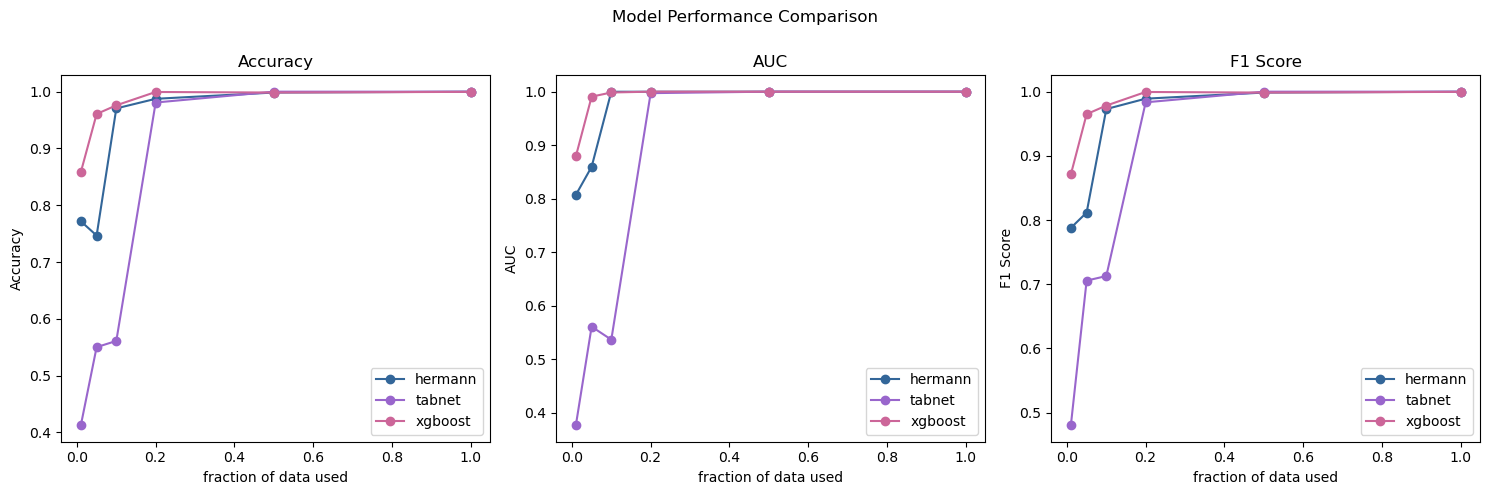

In [8]:
import matplotlib.pyplot as plt

# List of thresholds
thresholds = [1, 0.5, 0.2, 0.1, 0.05, 0.01]

results = []
for t in thresholds:
  results.append(run_all(1-t))

# List of metrics
metrics = ['Accuracy', 'AUC', 'F1 Score']

# Prepare the plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Model Performance Comparison')

# Plot the results
for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(thresholds, [r['hermann'][i] for r in results], label='hermann', marker='o',c=(0.2, 0.4, 0.6))
    ax.plot(thresholds, [r['tabnet'][i] for r in results], label='tabnet', marker='o',c=(0.6, 0.4, 0.8))
    ax.plot(thresholds, [r['xgboost'][i] for r in results], label='xgboost', marker='o',c=(0.8, 0.4, 0.6))
    ax.set_title(metric)
    ax.set_xlabel('fraction of data used')
    ax.set_ylabel(metric)
    ax.legend()

# Show the plot
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.savefig("result.png")
plt.show()